In [76]:
import nltk
import numpy as np
import re
import glob
import os
import tqdm
import sys
import json
import spacy
from scipy import linalg, mat, dot, stats
import torch
import torch.nn as nn
import pandas as pd
import seaborn as sns
from collections import OrderedDict
from scipy import linalg, mat, dot, stats
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

dataset = "ohsumed"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/adaptsystemlab2019/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/adaptsystemlab2019/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/adaptsystemlab2019/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [232]:
def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"patients ", "", string)
    return string.strip().lower()

def load_stopwords(filepath='../stopwords/stopwords_en.txt'):
    stopwords = set()
    with open(filepath, 'r') as f:
        for line in f:
            swd = line.strip()
            stopwords.add(swd)
    return stopwords

def cleanText(english_txt):
    stop_words = load_stopwords()
    stop_words.add('')
    try:
        word_tokens = english_txt.split()
        filtered_word = [w for w in word_tokens if w not in stop_words and not w.isdigit()]
        filtered_word = [w + " " for w in filtered_word]
        return "".join(filtered_word)
    except:
        return np.nan
def cleanNonEnglish(txt):
    txt = clean_str(txt)
    txt = re.sub(r'\W+', ' ', txt)
    txt = txt.lower()
    txt = txt.replace("[^a-zA-Z]", " ")
    word_tokens = txt.split()
    filtered_word = [w for w in word_tokens if all(ord(c) < 128 for c in w)]
    filtered_word = [w + " " for w in filtered_word]
    return "".join(filtered_word)

def reuptext(text_list):
    updata_text_list = []
    stop_word=load_stopwords()
    stop_word.add('')
    for sentence in text_list:
        updata_sentence = []
        for word in sentence.split(" "):
            if word not in stop_word:
                updata_sentence.append(word)
        updata_text_list.append(" ".join(updata_sentence))
    return updata_text_list

In [308]:
def wordFreq(docs):
    word_freq = {}
    for doc in docs:
        for word in doc.split():
            if word in word_freq:
                word_freq[word] += 1
            else:
                word_freq[word] = 1
    return word_freq
def evaluationFrequncy(docs,save_name="",limit_num=5,show_graph=False,show_analysis=True):
    '''evaluation frequncy for document lexions'''
    word_freq = wordFreq(docs)
    limit_word_freq_len = len([v for k,v in word_freq.items() if v < limit_num])
    word_freq_sorted = sorted(word_freq.items(), key = lambda kv:(kv[1], kv[0]))
    if show_analysis:
        print("=======analysis start=======")
        print("#all word size: ", len(word_freq))
        print("#frequncy < "+ str(limit_num) +": ", limit_word_freq_len)
        print("#frequncy mean: ", np.mean(list(word_freq.values())))
        print("#frequncy standard deviation: ", np.std(list(word_freq.values())))
        print("#frequncy std/mean: ", np.std(list(word_freq.values()))/np.mean(list(word_freq.values())))
    if show_graph:
        axes = sns.scatterplot(data=list(word_freq.values())).set_title(save_name)
        axes.figure.set_size_inches(18,4)
        fig = axes.get_figure()
        fig.savefig("../data/images/"+save_name+".png", dpi = 400)
    return word_freq, word_freq_sorted

In [84]:
def cleanSKB(skb):
    clean_skb = {}
    for word, items in tqdm.tqdm(skb.items()):
        if word not in clean_skb.keys():
            clean_skb[word] = []
        for (pos, sememe_set) in items:
            if word in clean_skb.keys() and len(sememe_set) != 0: 
                clean_skb[word].append((pos, sememe_set))
    return clean_skb

def removeWikiSenseOnSKBDA(skb_da_dict):
    '''uniform for SKB-DA sense'''
    skb_da_pure_dict = {}
    skb_da_cdv_set = set()
    for word, sense in tqdm.tqdm(skb_da_dict.items()):
        for (pos, sememe_set) in sense:
            if " (" in word:
                if len(word.split(" (")) == 3:
                    word, sense1,sense2 = word.split(" (")
                    sense1 = sense1.replace(")","")
                    sense2 = sense2.replace(")","")
                    if word not in skb_da_pure_dict.keys():
                        skb_da_pure_dict[word] = []
                    #sememe_set.add(sense1)
                    #sememe_set.add(sense2)
                    sememe_set.discard(word)
                    skb_da_pure_dict[word].append((sense1+" - "+sense2,sememe_set))
                    skb_da_cdv_set =  skb_da_cdv_set | sememe_set
                    continue
                word, sense = word.split(" (")
                sense = sense.replace(")","")
                if word not in skb_da_pure_dict.keys():
                    skb_da_pure_dict[word] = []
                #sememe_set.add(sense)
                sememe_set.discard(word)
                skb_da_pure_dict[word].append((sense,sememe_set))
                skb_da_cdv_set =  skb_da_cdv_set | sememe_set
            else:
                if word not in skb_da_pure_dict.keys():
                    skb_da_pure_dict[word] = []
                sememe_set.discard(word)
                skb_da_pure_dict[word].append((pos,sememe_set))
                skb_da_cdv_set =  skb_da_cdv_set | sememe_set
    print("#all lexicon of SKB-DA: {}; #CDV of SKB-DA: {}".format(len(skb_da_pure_dict),len(skb_da_cdv_set)))
    return cleanSKB(skb_da_pure_dict),skb_da_cdv_set

In [85]:
def cos(vec1,vec2):
    return vec1.dot(vec2)/(linalg.norm(vec1)*linalg.norm(vec2))
    
def catSememe(word, sememe_set, embedding_dict, upper_max):
    order_embedding_list = []
    if word not in embedding_dict.keys():
        word = '<unk>'
    for sememe in sememe_set:
        if sememe in embedding_dict:
            order_embedding_list.append(cos(embedding_dict[word],embedding_dict[sememe]))
        else:
            order_embedding_list.append(cos(embedding_dict[word],embedding_dict['<unk>']))
    sememe_set = list(sememe_set)
    return set(sememe_set[order_embedding_list.index(v)] for v in sorted(order_embedding_list)[-upper_max:])
    
def upperMaxSKB(skb_dict, embedding_dict, upper_max):
    limit_skb = {}
    for word, items in tqdm.tqdm(skb_dict.items()):
        if word not in limit_skb.keys():
            limit_skb[word] = []
        for (pos, sememe_set) in items:
            if len(sememe_set) > upper_max:
                a = catSememe(word, sememe_set,embedding_dict,upper_max)
                limit_skb[word].append((pos, a))
                #print(word,a)
            else:
                limit_skb[word].append((pos, sememe_set))
    return limit_skb

In [86]:
def loadGloveModel(gloveFile):
    '''Loading Glove Model'''
    f = open(gloveFile,'r', encoding='utf8')
    model = {}
    for line in tqdm.tqdm(f):
        splitLine = line.split(' ')
        word = splitLine[0]
        embedding = np.asarray(splitLine[1:], dtype='float32')
        model[word] = embedding
    print("Done.",len(model)," words loaded!")
    return model

In [332]:
def CosineSimilarity(x1, x2):
    x2 = x2.t()
    x = x1.mm(x2)
    x1_frobenius = x1.norm(dim=1).unsqueeze(0).t()
    x2_frobenins = x2.norm(dim=0).unsqueeze(0)
    x_frobenins = x1_frobenius.mm(x2_frobenins)
    final = x.mul(1/x_frobenins)
    return final
def localAttention(sentence_str, word_str, sememe_list, embedding_dict):
    '''
        input: sentence_str, word_str, embedding_dict
        oytput: word embedding
    '''
    #print(sentence_str, word_str)
    context_embedding_list = []
    sentence_list = sentence_str.split()
    if sentence_str != word_str:
        sentence_list.remove(word_str)
    for word in sentence_list:
        if word in embedding_dict.keys():
            context_embedding_list.append(embedding_dict[word])
        else:
            context_embedding_list.append(embedding_dict['<unk>'])

    context_embedding_list = torch.Tensor(context_embedding_list).to(device)
    word_embedding = torch.from_numpy(embedding_dict[word_str]).float().unsqueeze(0).to(device)
    #print(context_embedding_list.size(),word_embedding.size())
    cos_value_w = CosineSimilarity(context_embedding_list, word_embedding).to(device)
    softmax_nn = nn.Softmax(dim=0)
    softmax_weight_w = softmax_nn(cos_value_w) * 4
    '''
        get local word embedding
    '''
    local_word_embedding = softmax_weight_w.t().mm(context_embedding_list)
    
    
    sememes_embedding_list = []
    for sememe in sememe_list:
        if sememe in embedding_dict.keys():
            sememes_embedding_list.append(embedding_dict[sememe])
        else:
            sememes_embedding_list.append(embedding_dict['<unk>'])
            
    sememes_embedding_list = torch.Tensor(sememes_embedding_list).to(device)
    cos_value_s = CosineSimilarity(sememes_embedding_list, local_word_embedding).to(device)
    softmax_weight_s = softmax_nn(cos_value_s) * 2
    local_sememe_embedding = softmax_weight_s.t().mm(sememes_embedding_list)
    cos_value = CosineSimilarity(local_sememe_embedding,local_word_embedding)
    
    return cos_value.to('cpu').squeeze(0).numpy().tolist()

def replaceWord2Sememe(embedding_dict, skb_dict, docs_tuple,threshold,skb_cdv_map,ferquncy_max=0,overwrite=False):
    '''
        input: 
        process: if the word of sentence in skb && else if the freqency of word less then threshold:
                    replace the word to sememe:
                        if the sense of word only once:
                            straightforward replace else more thinking... of (sense dismatching- now leave aside)
                        else:
                            search the sentence embedding of docs by look-up embedding dictionary
                            for building the word embedding with weighted sum of sentence:
                                senses cosin = list
                                for index, sense the enumerate(senses):
                                    word cosin = list
                                    for sememe in sense:
                                        compare both that the embedding of the word and the sememe of the sense
                                        append the cosin value to word cosin list
                                    keep minimum of senses cosin to append the senses cosin list
                                get the index of minimum value for sense senses list
                                get the word via index with this word senses of SKB-DA
                            replace  
        return: docs list replaced with sememe
    '''
    sememe_docs_list = []

    '''
        threshold = np.mean(list(docs_tuple[0].values())) + np.std(list(word_freq.values())) /\
                np.mean(list(word_freq.values()))
    '''
    threshold = threshold
    ferquncy_max_word_list = [word for (word,_) in raw_word_freq_sorted[-round(ferquncy_max*len(docs_tuple[2])):]]
    for sentence in tqdm.tqdm(docs_tuple[2]):
        sentence_replace = []
        for word in sentence.split():
            #print("####",word)
            if word in skb_dict.keys() and (docs_tuple[0][word] < threshold or word in ferquncy_max_word_list):
                if len(skb_dict[word]) == 1:
                    if overwrite:
                        sentence_replace += ["<S"+str(skb_cdv_map[sememe])+">" \
                                        for sememe in list(skb_dict[word][0][1])]
                    else:
                        sentence_replace += list(skb_dict[word][0][1])
                else:
                    if word not in embedding_dict.keys():
                        if overwrite:
                            sentence_replace += ["<S"+str(skb_cdv_map[sememe])+">" \
                                              for sememe in list(skb_dict[word][0][1])]
                        else:
                            sentence_replace += list(skb_dict[word][0][1])
                    else:
                        senses_cos_list = []
                        for (_, sememe_set) in skb_dict[word]:
                            senses_cos_list.append(localAttention(\
                                                sentence, word, list(sememe_set), embedding_dict)[0])
                            #print(senses_cos_list)
                        if len(senses_cos_list) == 0:
                            sentence_replace.append(word)
                            continue
                        senses_cos_list_max_index = senses_cos_list.index(max(senses_cos_list))
                        if overwrite:
                            sentence_replace += ["<S"+str(skb_cdv_map[sememe])+">" \
                                              for sememe in list(skb_dict[word][senses_cos_list_max_index][1]) ]
                        else:
                            sentence_replace += list(skb_dict[word][senses_cos_list_max_index][1])          
            else:
                sentence_replace.append(word)
        sememe_docs_list.append(" ".join(sentence_replace))
    return sememe_docs_list

In [216]:
def cleanBySKB(embedding_dict, skb_dict, doc_content_tuple, ferquncy_mix, skb_cdv_map, ferquncy_max):
    sememe_docs_list = replaceWord2Sememe(embedding_dict,\
                                      skb_dict,\
                                      doc_content_tuple,\
                                      ferquncy_mix,skb_cdv_map,ferquncy_max)
    clean_word_freq, clean_word_freq_sorted = evaluationFrequncy(sememe_docs_list,"clran_ohsumed",ferquncy_mix)
    return (clean_word_freq, clean_word_freq_sorted,sememe_docs_list)

In [314]:
def skbToList(skb):
    skb_list = []
    for items in skb.values():
        for sense in items:
            skb_list.append(" ".join(sense[1]))
    return skb_list

def getStopSememes(skb,upper_limit,lower_limit):
    sememe_freq, sememe_sorted = evaluationFrequncy(skbToList(skb))
    stopsememes_upper = [sememe for (sememe,_) in sememe_sorted[-round(len(sememe_sorted)*upper_limit):]]
    stopsememes_lower = [sememe for (sememe,_) in sememe_sorted[:round(len(sememe_sorted)*lower_limit)]]
    return set(stopsememes_upper + stopsememes_lower)

def removeStopSememes(skb,upper_limit=0.05,lower_limit=0.05):
    stopsememes_set = getStopSememes(skb,upper_limit,lower_limit)
    skb_clean = {}
    for word, senses in skb.items():
        senses_list_clean = []
        for (pos,sememe_set) in senses:
            sememe_set_clean = set()
            for sememe in sememe_set:
                if sememe not in stopsememes_set:
                    sememe_set_clean.add(sememe)
            if len(sememe_set_clean) != 0:
                senses_list_clean.append((pos,sememe_set_clean))
        if len(senses_list_clean) != 0:
            skb_clean[word] = senses_list_clean
    return skb_clean

In [133]:
def _networkskbForm(networkskb):
    '''uniform for NetWorkSKB'''
    networkskb_form = {}
    for wn_k,wn_v in networkskb.items():
        word = wn_k.split(".")[0]
        if word not in networkskb_form.keys():
            networkskb_form[word] = []
        networkskb_form[word].append((wn_k.split(".")[1],wn_v))
    return networkskb_form

In [43]:
STC_Benchmark_path = "../benchmark"
Ohsumed_training: dict = np.load(STC_Benchmark_path+"/Ohsumed/Ohsumed_training.npy", allow_pickle=True).tolist()
Ohsumed_test: dict = np.load(STC_Benchmark_path+"/Ohsumed/Ohsumed_test.npy", allow_pickle=True).tolist()
Ohsumed_category_description: dict = np.load(STC_Benchmark_path+"/Ohsumed/Ohsumed_category_description.npy", allow_pickle=True).tolist()
Ohsumed_ohsumed_all: dict = np.load(STC_Benchmark_path+"/Ohsumed/Ohsumed_ohsumed_all.npy", allow_pickle=True).tolist()

In [334]:
doc_content_lemmatization_tuple: tuple = np.load("../data/corpus/" + dataset+".clean.lemmatization.npy",\
                                                 allow_pickle=True).tolist()
doc_content_tuple: tuple = np.load("../data/corpus/" + dataset+".clean.npy", allow_pickle=True).tolist()

In [339]:
skb_da = np.load("../sememe_dataset/skb_ad_dict.npy", allow_pickle=True).tolist()
dictskb = np.load("../sememe_dataset/DictSKB_dict.npy", allow_pickle=True).tolist()
networkskb = np.load("../sememe_dataset/sememe_network_dict_en_wordnet_5000.npy", allow_pickle=True).tolist()

In [340]:
skb_da_pure,skb_da_pure_cdv_set = removeWikiSenseOnSKBDA(skb_da)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 910369/910369 [01:27<00:00, 10350.20it/s]


#all lexicon of SKB-DA: 800795; #CDV of SKB-DA: 5000


100%|███████████████████████████████████████████████████████████████████████████████████████████| 800795/800795 [00:03<00:00, 251616.56it/s]


In [341]:
skb_da_cdv_map = {word:index for index, word in enumerate(skb_da_pure_cdv_set)}

In [92]:
glove_840B_300d_common_crawl = loadGloveModel("../data/embeddings/glove.840B.300d.common_crawl.txt")

2196018it [01:11, 30561.76it/s]

Done. 2196017  words loaded!


In [357]:
skb_da_upper_max = upperMaxSKB(skb_da_pure,glove_840B_300d_common_crawl,4)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 539256/539256 [00:16<00:00, 33236.36it/s]


=======analysis start=======
#all word size:  4500
#frequncy < 5:  0
#frequncy mean:  371.5684444444444
#frequncy standard deviation:  345.8729914350742
#frequncy std/mean:  0.9308459763105311


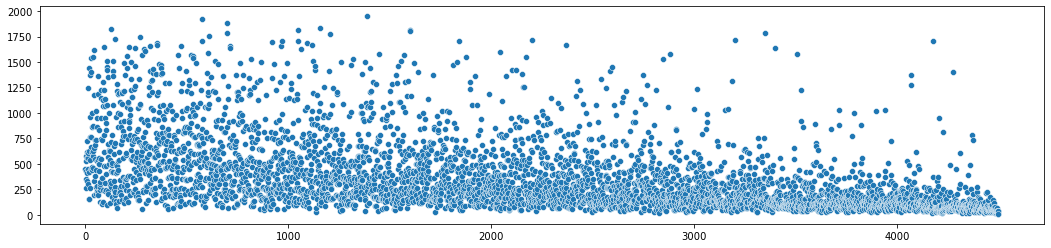

In [358]:
sememe_freq, sememe_sorted = evaluationFrequncy(skbToList(skb_da_upper_max),show_graph=True)

=======analysis start=======
#all word size:  1431
#frequncy < 5:  19
#frequncy mean:  147.49755415793152
#frequncy standard deviation:  315.81668308936406
#frequncy std/mean:  2.1411655596079004


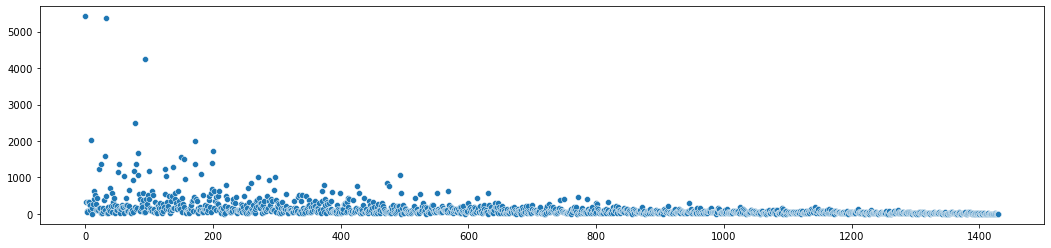

In [294]:
sememe_freq, sememe_sorted = evaluationFrequncy(skbToList(dictskb),show_graph=True)

=======analysis start=======
#all word size:  5000
#frequncy < 5:  0
#frequncy mean:  115.873
#frequncy standard deviation:  230.98063137631257
#frequncy std/mean:  1.9933947630277336


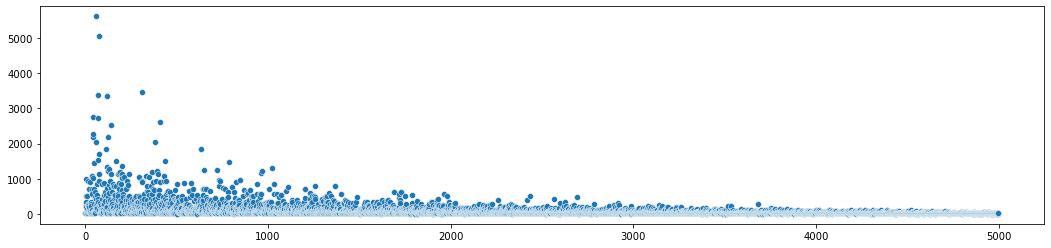

In [292]:
sememe_freq, sememe_sorted = evaluationFrequncy(skbToList(networkskb),show_graph=True)

In [342]:
skb_da_pure = removeStopSememes(skb_da_pure,upper_limit=0.1,lower_limit=0)

=======analysis start=======
#all word size:  5000
#frequncy < 5:  0
#frequncy mean:  875.396
#frequncy standard deviation:  1449.2654401399352
#frequncy std/mean:  1.655554103674149


=======analysis start=======
#all word size:  4500
#frequncy < 5:  0
#frequncy mean:  636.152
#frequncy standard deviation:  636.4449666410025
#frequncy std/mean:  1.000460529309037


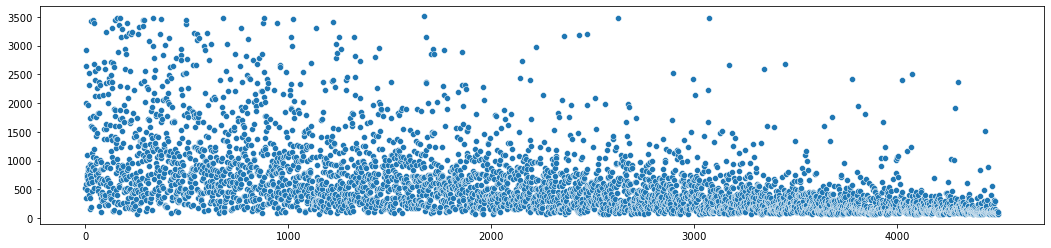

In [316]:
sememe_freq, sememe_sorted = evaluationFrequncy(skbToList(skb_da_pure),show_graph=True)

=======analysis start=======
#all word size:  4500
#frequncy < 5:  0
#frequncy mean:  494.36333333333334
#frequncy standard deviation:  421.4322312595994
#frequncy std/mean:  0.8524746939017849


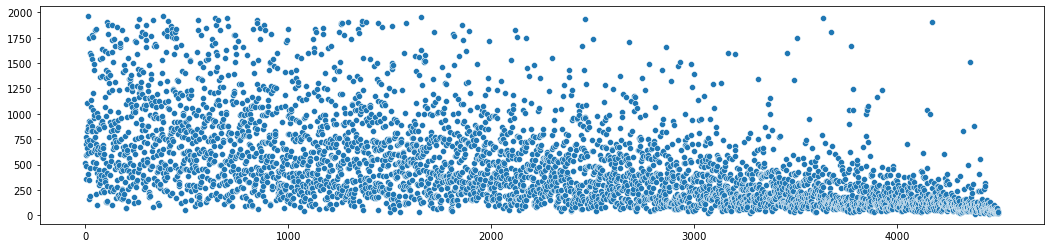

In [343]:
sememe_freq, sememe_sorted = evaluationFrequncy(skbToList(skb_da_pure),show_graph=True)

In [136]:
networkskb = _networkskbForm(networkskb)

In [378]:
Ohsumed_list = [k for k,v in Ohsumed_test.items()] + [k for k,v in Ohsumed_training.items()]
Ohsumed_list = reuptext(Ohsumed_list)
#Ohsumed_list = [cleanText(cleanNonEnglish(sentence).strip()).strip() for sentence in Ohsumed_list]
raw_word_freq, raw_word_freq_sorted = evaluationFrequncy(Ohsumed_list,"raw_ohsumed",limit_num=5)
doc_content_tuple = (raw_word_freq,raw_word_freq_sorted,Ohsumed_list)

=======analysis start=======
#all word size:  18184
#frequncy < 5:  15629
#frequncy mean:  3.5218873735151783
#frequncy standard deviation:  11.697084349166726
#frequncy std/mean:  3.3212545174299324


In [379]:
doc_content_tuple = cleanBySKB(glove_840B_300d_common_crawl,\
                               skb_da_upper_max,doc_content_tuple,5,skb_da_cdv_map,0)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 7400/7400 [02:02<00:00, 60.57it/s]

=======analysis start=======
#all word size:  15810
#frequncy < 5:  12785
#frequncy mean:  7.878368121442125
#frequncy standard deviation:  33.32265651452732
#frequncy std/mean:  4.229639438126134


In [180]:
doc_content_tuple = cleanBySKB(glove_840B_300d_common_crawl,skb_da_pure,doc_content_tuple,5,skb_da_cdv_map)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 7400/7400 [00:00<00:00, 130365.67it/s]

=======analysis start=======
#all word size:  17747
#frequncy < 5:  13299
#frequncy mean:  5.214120696455739
#frequncy standard deviation:  13.69576692790837
#frequncy std/mean:  2.6266685650790493


In [380]:
skb_Ohsumed = doc_content_tuple[2]

In [ ]:
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')
X_train = newsgroups_train.data
X_test = newsgroups_test.data
y_train = newsgroups_train.target
y_test = newsgroups_test.target

## Naive Bayes Classifier

In [155]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.datasets import fetch_20newsgroups

In [266]:
newsgroups_list = newsgroups_train.data + newsgroups_test.data
newsgroups_list = [cleanText(cleanNonEnglish(sentence).strip()).strip() for sentence in newsgroups_list]
raw_word_freq, raw_word_freq_sorted = evaluationFrequncy(newsgroups_list,"raw_ohsumed",limit_num=5)
doc_content_tuple = (raw_word_freq,raw_word_freq_sorted,newsgroups_list)
newsgroups = cleanBySKB(glove_840B_300d_common_crawl,\
                               skb_da_upper_max,doc_content_tuple,5,skb_da_cdv_map,0.0001)

=======analysis start=======
#all word size:  154234
#frequncy < 5:  114539
#frequncy mean:  19.57630613224062
#frequncy standard deviation:  247.79825654870734
#frequncy std/mean:  12.658070162715902


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 18846/18846 [11:09:03<00:00,  2.13s/it]


=======analysis start=======
#all word size:  139575
#frequncy < 5:  96209
#frequncy mean:  22.965251656815333
#frequncy standard deviation:  278.0766762522217
#frequncy std/mean:  12.108583890466434


In [376]:

X_train = reuptext(list(Ohsumed_training.keys()))
X_test = reuptext(list(Ohsumed_test.keys()))
y_train = [v[0] for v in list(Ohsumed_training.values())]
y_test = [v[0] for v in list(Ohsumed_test.values())]

In [377]:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
                     ])
text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

         C01       1.00      0.02      0.04       102
         C02       0.00      0.00      0.00        50
         C03       0.00      0.00      0.00        29
         C04       0.45      0.82      0.58       600
         C05       0.00      0.00      0.00       140
         C06       0.82      0.05      0.10       178
         C07       0.00      0.00      0.00        34
         C08       0.00      0.00      0.00       129
         C09       0.00      0.00      0.00        28
         C10       0.88      0.04      0.08       342
         C11       0.00      0.00      0.00        76
         C12       1.00      0.01      0.02       187
         C13       0.50      0.01      0.02       103
         C14       0.23      0.98      0.37       590
         C15       0.00      0.00      0.00        79
         C16       0.00      0.00      0.00        70
         C17       1.00      0.02      0.03       132
         C18       0.96    

/home/adaptsystemlab2019/yes/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/adaptsystemlab2019/yes/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/adaptsystemlab2019/yes/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [381]:
X_train = skb_Ohsumed[len(Ohsumed_test):]
X_test = skb_Ohsumed[:len(Ohsumed_test)]
y_train = [v[0] for v in list(Ohsumed_training.values())]
y_test = [v[0] for v in list(Ohsumed_test.values())]

In [382]:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
                     ])
text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

         C01       0.00      0.00      0.00       102
         C02       0.00      0.00      0.00        50
         C03       0.00      0.00      0.00        29
         C04       0.41      0.73      0.53       600
         C05       0.00      0.00      0.00       140
         C06       0.86      0.03      0.06       178
         C07       0.00      0.00      0.00        34
         C08       0.00      0.00      0.00       129
         C09       0.00      0.00      0.00        28
         C10       0.67      0.01      0.02       342
         C11       0.00      0.00      0.00        76
         C12       0.00      0.00      0.00       187
         C13       0.00      0.00      0.00       103
         C14       0.21      0.98      0.35       590
         C15       0.00      0.00      0.00        79
         C16       0.00      0.00      0.00        70
         C17       0.00      0.00      0.00       132
         C18       0.88    

/home/adaptsystemlab2019/yes/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/adaptsystemlab2019/yes/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/adaptsystemlab2019/yes/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [242]:
skb_Ohsumed: list = np.load("./cleandocs_stc_sl4_f10_once.npy", allow_pickle=True).tolist()
X_train = skb_Ohsumed[len(Ohsumed_test):]
X_test = skb_Ohsumed[:len(Ohsumed_test)]
y_train = [v[0] for v in list(Ohsumed_training.values())]
y_test = [v[0] for v in list(Ohsumed_test.values())]
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
                     ])
text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

         C01       0.83      0.10      0.18       102
         C02       0.00      0.00      0.00        50
         C03       0.00      0.00      0.00        29
         C04       0.43      0.87      0.58       600
         C05       0.00      0.00      0.00       140
         C06       1.00      0.12      0.21       178
         C07       0.00      0.00      0.00        34
         C08       1.00      0.01      0.02       129
         C09       0.00      0.00      0.00        28
         C10       0.76      0.05      0.09       342
         C11       0.00      0.00      0.00        76
         C12       0.83      0.03      0.05       187
         C13       1.00      0.01      0.02       103
         C14       0.25      0.99      0.40       590
         C15       0.00      0.00      0.00        79
         C16       0.00      0.00      0.00        70
         C17       1.00      0.02      0.03       132
         C18       0.97    

/home/adaptsystemlab2019/yes/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/adaptsystemlab2019/yes/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/adaptsystemlab2019/yes/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [117]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.datasets import fetch_20newsgroups

X_train = reuptext(list(Ohsumed_training.keys()))
X_test = reuptext(list(Ohsumed_test.keys()))
y_train = [v[0] for v in list(Ohsumed_training.values())]
y_test = [v[0] for v in list(Ohsumed_test.values())]

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', KNeighborsClassifier()),
                     ])

text_clf.fit(X_train, y_train)

predicted = text_clf.predict(X_test)

print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

         C01       0.24      0.47      0.32       102
         C02       0.30      0.20      0.24        50
         C03       0.54      0.45      0.49        29
         C04       0.46      0.77      0.58       600
         C05       0.39      0.32      0.35       140
         C06       0.40      0.54      0.46       178
         C07       0.33      0.15      0.20        34
         C08       0.35      0.36      0.35       129
         C09       0.50      0.32      0.39        28
         C10       0.57      0.44      0.49       342
         C11       0.75      0.28      0.40        76
         C12       0.51      0.37      0.43       187
         C13       0.65      0.36      0.46       103
         C14       0.55      0.77      0.64       590
         C15       0.48      0.28      0.35        79
         C16       0.54      0.29      0.37        70
         C17       0.68      0.51      0.58       132
         C18       0.55    

/home/adaptsystemlab2019/yes/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/adaptsystemlab2019/yes/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/adaptsystemlab2019/yes/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [355]:
X_train = skb_Ohsumed[len(Ohsumed_test):]
X_test = skb_Ohsumed[:len(Ohsumed_test)]
y_train = [v[0] for v in list(Ohsumed_training.values())]
y_test = [v[0] for v in list(Ohsumed_test.values())]
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', KNeighborsClassifier()),
                     ])

text_clf.fit(X_train, y_train)

predicted = text_clf.predict(X_test)

print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

         C01       0.20      0.41      0.27       102
         C02       0.15      0.08      0.11        50
         C03       0.52      0.45      0.48        29
         C04       0.42      0.69      0.52       600
         C05       0.35      0.25      0.29       140
         C06       0.26      0.34      0.29       178
         C07       0.23      0.09      0.13        34
         C08       0.17      0.15      0.16       129
         C09       0.33      0.18      0.23        28
         C10       0.45      0.27      0.33       342
         C11       0.53      0.22      0.31        76
         C12       0.34      0.20      0.26       187
         C13       0.46      0.28      0.35       103
         C14       0.46      0.71      0.55       590
         C15       0.44      0.25      0.32        79
         C16       0.42      0.14      0.21        70
         C17       0.52      0.30      0.38       132
         C18       0.53    

svm

In [208]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.datasets import fetch_20newsgroups

X_train = reuptext(list(Ohsumed_training.keys()))
X_test = reuptext(list(Ohsumed_test.keys()))
y_train = [v[0] for v in list(Ohsumed_training.values())]
y_test = [v[0] for v in list(Ohsumed_test.values())]

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', LinearSVC()),
                     ])

text_clf.fit(X_train, y_train)


predicted = text_clf.predict(X_test)

print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

         C01       0.61      0.50      0.55       102
         C02       0.60      0.18      0.28        50
         C03       0.83      0.52      0.64        29
         C04       0.68      0.79      0.73       600
         C05       0.66      0.43      0.52       140
         C06       0.55      0.64      0.59       178
         C07       0.80      0.24      0.36        34
         C08       0.62      0.55      0.58       129
         C09       0.56      0.36      0.43        28
         C10       0.64      0.54      0.59       342
         C11       0.71      0.36      0.47        76
         C12       0.68      0.55      0.61       187
         C13       0.65      0.50      0.57       103
         C14       0.64      0.85      0.73       590
         C15       0.65      0.42      0.51        79
         C16       0.51      0.31      0.39        70
         C17       0.67      0.62      0.65       132
         C18       0.61    

In [354]:
X_train = skb_Ohsumed[len(Ohsumed_test):]
X_test = skb_Ohsumed[:len(Ohsumed_test)]
y_train = [v[0] for v in list(Ohsumed_training.values())]
y_test = [v[0] for v in list(Ohsumed_test.values())]

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', LinearSVC()),
                     ])

text_clf.fit(X_train, y_train)


predicted = text_clf.predict(X_test)

print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

         C01       0.49      0.51      0.50       102
         C02       0.77      0.20      0.32        50
         C03       0.86      0.62      0.72        29
         C04       0.68      0.77      0.72       600
         C05       0.60      0.38      0.46       140
         C06       0.55      0.56      0.56       178
         C07       0.31      0.12      0.17        34
         C08       0.50      0.34      0.41       129
         C09       0.42      0.29      0.34        28
         C10       0.52      0.48      0.50       342
         C11       0.69      0.47      0.56        76
         C12       0.62      0.48      0.54       187
         C13       0.57      0.41      0.47       103
         C14       0.59      0.80      0.68       590
         C15       0.60      0.32      0.41        79
         C16       0.55      0.26      0.35        70
         C17       0.57      0.52      0.55       132
         C18       0.53    

/home/adaptsystemlab2019/yes/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/adaptsystemlab2019/yes/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/adaptsystemlab2019/yes/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
